In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Load Datasets
data1 = pd.read_csv('bank-additional.csv', sep=';')  
data2 = pd.read_csv('bank.csv', sep=';')  
print("Datasets Loaded Successfully!")

Datasets Loaded Successfully!


In [3]:
# Optional: Gabungkan dataset jika diperlukan
# data = pd.concat([data1, data2], axis=0).reset_index(drop=True)
# Atau, pilih salah satu dataset yang lebih sesuai
data = data1  # Contoh menggunakan data1; sesuaikan jika ingin menggunakan data2

In [4]:
# Data Understanding
print("Info Data:", data.info())
print("Data Awal:\n", data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

In [6]:
# Data Understanding dan Exploratory Data Analysis (EDA)
print("Descriptive Statistics:\n", data.describe())

Descriptive Statistics:
                age     duration     campaign        pdays     previous  \
count  4119.000000  4119.000000  4119.000000  4119.000000  4119.000000   
mean     40.113620   256.788055     2.537266   960.422190     0.190337   
std      10.313362   254.703736     2.568159   191.922786     0.541788   
min      18.000000     0.000000     1.000000     0.000000     0.000000   
25%      32.000000   103.000000     1.000000   999.000000     0.000000   
50%      38.000000   181.000000     2.000000   999.000000     0.000000   
75%      47.000000   317.000000     3.000000   999.000000     0.000000   
max      88.000000  3643.000000    35.000000   999.000000     6.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx    euribor3m  nr.employed  
count   4119.000000     4119.000000    4119.000000  4119.000000  4119.000000  
mean       0.084972       93.579704     -40.499102     3.621356  5166.481695  
std        1.563114        0.579349       4.594578     1.733591    73.6

In [7]:
# Encode semua kolom kategorikal menjadi numerik sebelum memplot korelasi
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

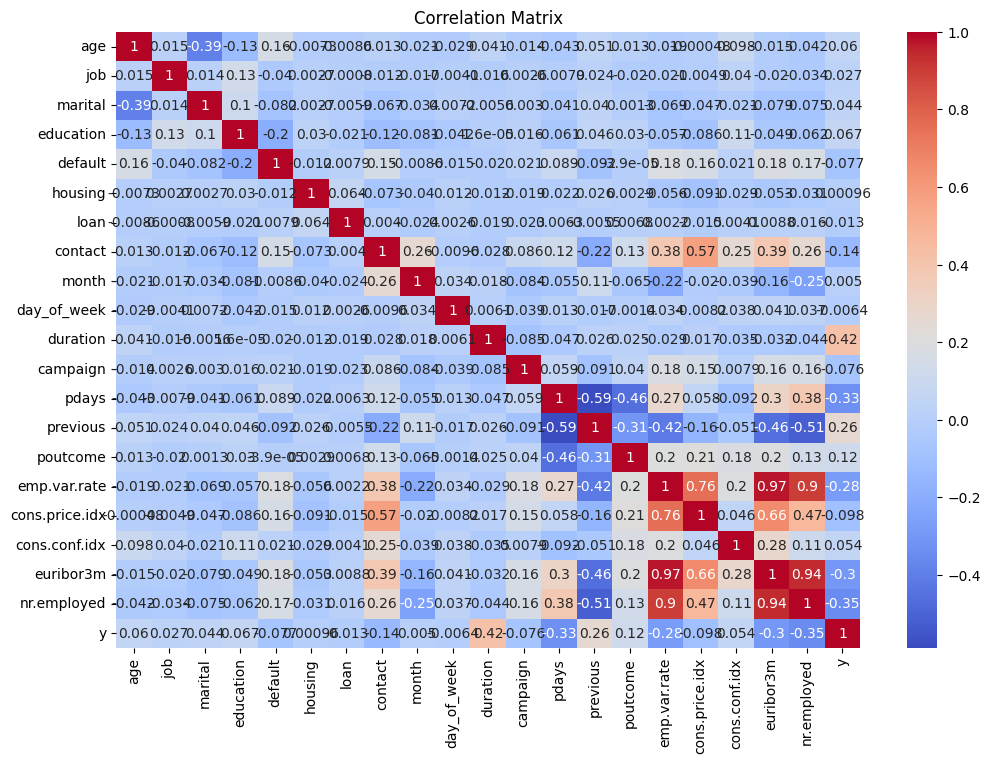

In [8]:
# Plot Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [9]:
# Handle missing values
data.fillna(data.mean(), inplace=True)

In [10]:
# Feature Selection
X = data.drop('y', axis=1)  # 'y' adalah kolom target
y = data['y']

In [11]:
print("\n---Feature Selection---")
model = DecisionTreeClassifier(random_state=42)
selector = RFE(model, n_features_to_select=15, step=1)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.support_]
print("Selected Features:", selected_features)


---Feature Selection---
Selected Features: Index(['age', 'job', 'marital', 'education', 'contact', 'month', 'day_of_week',
       'duration', 'campaign', 'pdays', 'previous', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')


In [12]:
# Train-test split
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_selected, X_test_selected, _, _ = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [13]:
# Standardize data
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test_full = scaler.transform(X_test_full)
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)


In [19]:
# Modeling and Evaluation with Cross-Validation
print("\n---Modeling and Evaluation---")
models = {
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

scores_full = {}
scores_selected = {}
for name, model in models.items():
    print(f"\nModel: {name} on Original Data")
    model.fit(X_train_full, y_train)
    y_pred_full = model.predict(X_test_full)
    cm_full = confusion_matrix(y_test, y_pred_full)
    print("Confusion Matrix (Original):\n", cm_full)
    print("Classification Report (Original):\n", classification_report(y_test, y_pred_full))
    cv_scores_full = cross_val_score(model, X_train_full, y_train, cv=5)
    scores_full[name] = (cv_scores_full.mean(), cv_scores_full.std())
    
    print(f"\nModel: {name} on Selected Features")
    model.fit(X_train_selected, y_train)
    y_pred_selected = model.predict(X_test_selected)
    cm_selected = confusion_matrix(y_test, y_pred_selected)
    print("Confusion Matrix (Selected):\n", cm_selected)
    print("Classification Report (Selected):\n", classification_report(y_test, y_pred_selected))
    cv_scores_selected = cross_val_score(model, X_train_selected, y_train, cv=5)
    scores_selected[name] = (cv_scores_selected.mean(), cv_scores_selected.std())


---Modeling and Evaluation---

Model: Naive Bayes on Original Data
Confusion Matrix (Original):
 [[651  81]
 [ 39  53]]
Classification Report (Original):
               precision    recall  f1-score   support

           0       0.94      0.89      0.92       732
           1       0.40      0.58      0.47        92

    accuracy                           0.85       824
   macro avg       0.67      0.73      0.69       824
weighted avg       0.88      0.85      0.87       824


Model: Naive Bayes on Selected Features
Confusion Matrix (Selected):
 [[674  58]
 [ 42  50]]
Classification Report (Selected):
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       732
           1       0.46      0.54      0.50        92

    accuracy                           0.88       824
   macro avg       0.70      0.73      0.72       824
weighted avg       0.89      0.88      0.88       824


Model: K-Nearest Neighbors on Original Data
Confusion Matrix

In [18]:
# Comparison Analysis
print("\n---Comparison Analysis---")
for name in models.keys():
    print(f"{name}:")
    print(f"Original Data - Mean CV Score: {scores_full[name][0]:.4f} ± {scores_full[name][1]:.4f}")
    print(f"Selected Data - Mean CV Score: {scores_selected[name][0]:.4f} ± {scores_selected[name][1]:.4f}")
    print()


---Comparison Analysis---
Naive Bayes:
Original Data - Mean CV Score: 0.8507 ± 0.0096
Selected Data - Mean CV Score: 0.8853 ± 0.0093

K-Nearest Neighbors:
Original Data - Mean CV Score: 0.9047 ± 0.0044
Selected Data - Mean CV Score: 0.9035 ± 0.0045

Decision Tree:
Original Data - Mean CV Score: 0.8856 ± 0.0105
Selected Data - Mean CV Score: 0.8880 ± 0.0093

